In [ ]:
#| hide
from ready_steady_go.benchmark import *

# Ready, Steady, Go!



It's fall 2022, and for the first time in years, buying a GPU for Deep Learning experiments does not sound too crazy.

Now, how do we pick one?

> Keep in mind, performance depends on many factors, not least your CPU and often SSD.\
> For experiments, you might be better off with 2 cheaper GPUs - one to run in background, the other used interactively.



# My Results

In [ ]:
# |code-fold: true
# |code-summary: "Imports"

import wandb
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
# |code-fold: true
# |code-summary: "Style"

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

gpu_names = {   'NVIDIA GeForce GTX 1060 6GB'   : '1060 6G',
                'GeForce RTX 3090'              : '3090',
                'NVIDIA GeForce RTX 3060'       : '3060',
                'NVIDIA GeForce RTX 2080 Ti'    : '2080 Ti',
                'NVIDIA A100-PCIE-40GB'         : 'A100 PCIE 40G',
                'NVIDIA GeForce RTX 3080 Ti'    : '3080 Ti',
                'NVIDIA GeForce GTX 1080 Ti'    : '1080 Ti',
                'NVIDIA A100-SXM4-80GB'         : 'A100 SXM4 80G'
}

I ran the benchmark on a variety of GPUs from [vast.ai](https://vast.ai).
The results are automatically synced to [Weights & Biases](https://wandb.ai). 

In [ ]:
# |code-fold: true
# |code-summary: "Retrieve and clean up data"

api = wandb.Api()

runs = api.runs("xl0/ready-steady-go")
summaries = [ dict(r.summary) | {"id": r.id} for r in runs if r.state == "finished"]

df = pd.DataFrame.from_records(summaries)

df = df[["device_name", "model", "bs", "fp16", "throughput"]]
df["fp16"] = df["fp16"].apply(lambda x: "FP16" if x else "FP32")
df = df.replace({"device_name" : gpu_names})
df.dropna(inplace=True)

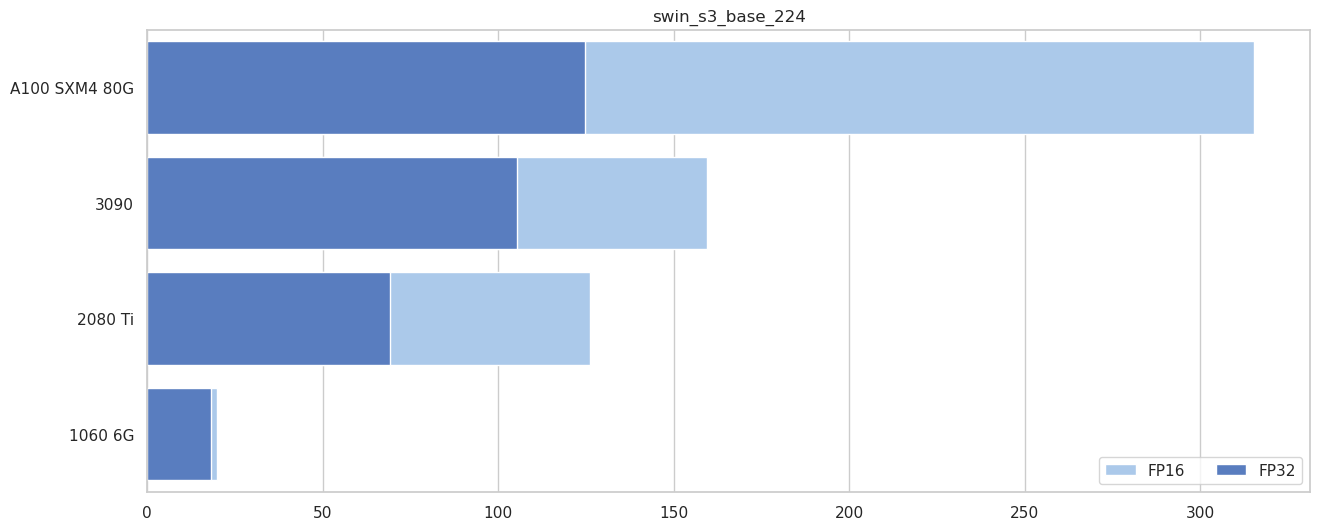

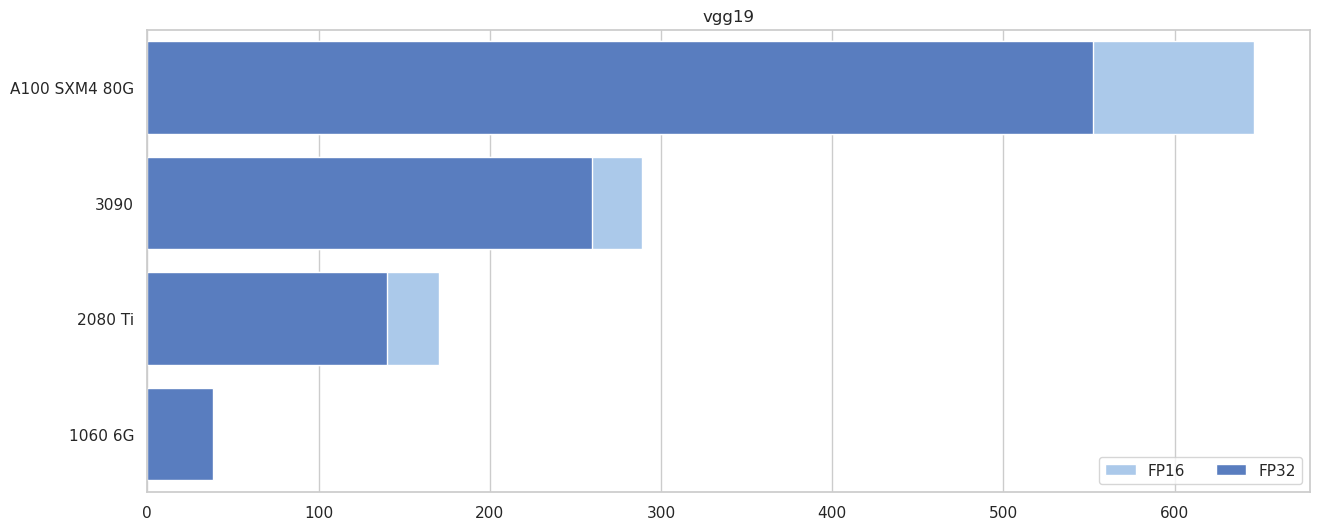

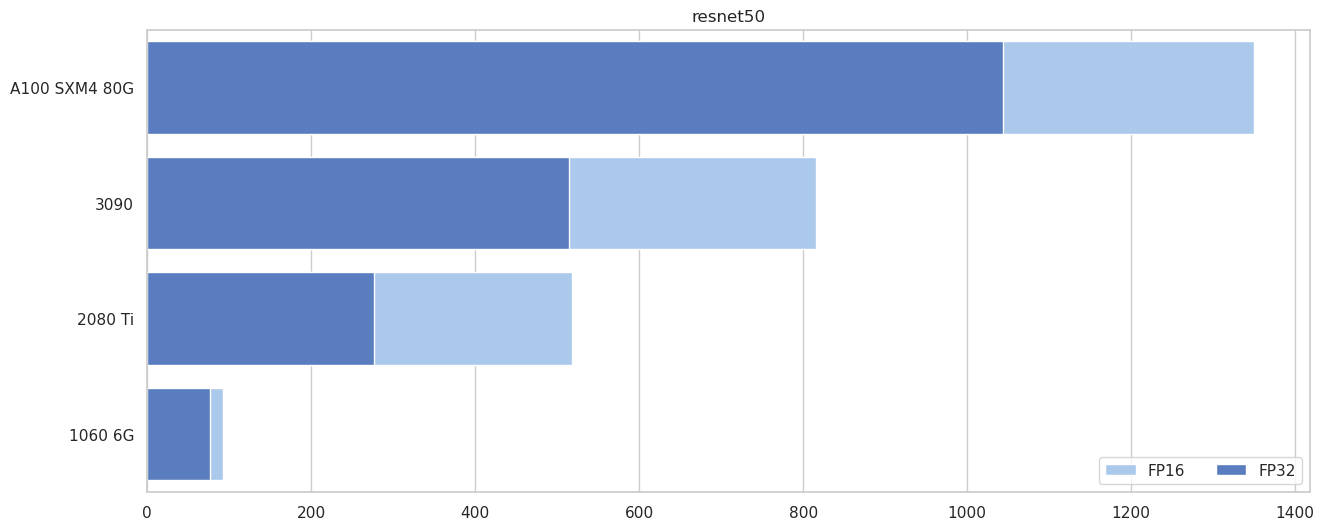

In [ ]:
# |code-fold: true
# |code-summary: "Plot GPU performance"

# For each device/model/fp size, get the index of the entry with the highest throughput.
max_bs_idx = df.groupby(["device_name", "model", "fp16"])["throughput"].idxmax()

for model in df.model.unique():
    f, ax = plt.subplots(figsize=(15, 6))
    
    tops = df.loc[max_bs_idx].sort_values("throughput", ascending=False)

    sns.set_color_codes("pastel")
    sns.barplot(ax=ax, data=tops.loc[tops.fp16.eq('FP16') & tops.model.eq(model)],
                x="throughput", y="device_name", label="FP16", color="b")

    sns.set_color_codes("muted")
    sns.barplot(ax=ax, data=tops.loc[tops.fp16.eq('FP32') & tops.model.eq(model)],
                x="throughput", y="device_name", label="FP32", color="b")

    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel=None, xlabel=None, title=model)
